## Load the data from pickle files

In [89]:
import pickle
import os
from tqdm import tqdm
import numpy as np

directory = 'data/train'

length_list = []
valence_values=[]

recordings = []

for filename in tqdm(os.listdir(directory)):
    if filename.endswith('.pkl'):
        file_path = os.path.join(directory, filename)
        with open(file_path, 'rb') as file:
            data = pickle.load(file)
            if data['valence'] != 2.333 and len(data['audio_data']) < 91000:
                length_list.append(len(data['audio_data']))
                valence_values.append(data['valence'])
                recordings.append(data['audio_data'])

valence_values = np.array(valence_values)
len(recordings)

100%|██████████| 10557/10557 [00:11<00:00, 951.98it/s]


10391

In [90]:
def round_to_nearest_quarter(number):
    # Assuming 'number' could be a numpy array with a single value
    if isinstance(number, np.ndarray) and number.size == 1:
        number = number.item()  # Convert single-item array to scalar
    
    # Ensure the number is within the 1 to 5 range before processing
    number = np.clip(number, 1, 5)
    # Scale number to shift quarters to whole numbers, round, and rescale
    rounded_number = np.round(number * 4) / 4
    # Clip again to ensure no out-of-range values after rounding
    rounded_number = np.clip(rounded_number, 1, 5)
    return rounded_number

In [91]:
valence_dict = {}

for i in valence_values:
    if i not in valence_dict:
        valence_dict[i] = 1
    else:
        valence_dict[i] += 1


In [92]:
valence_dict

{1.25: 140,
 3.5: 1173,
 3.25: 1273,
 3.75: 972,
 2.0: 523,
 2.75: 1014,
 2.25: 679,
 3.0: 1045,
 4.25: 606,
 1.0: 114,
 1.5: 227,
 1.75: 407,
 4.75: 151,
 4.0: 784,
 2.5: 890,
 5.0: 28,
 4.5: 365}

## **Padding to unify the length of the arrays**

In [93]:

max_length = max(len(array) for array in recordings)  # Find the maximum length

# Pad each array to have the maximum length
padded_arrays = np.array([np.pad(array, (0, max_length - len(array)), mode='constant') for array in recordings])

### Create train, test, validation sets

In [110]:
from sklearn.model_selection import train_test_split

# Split the data and labels into training and testing sets
X_train, X_test_help, y_train, y_test_help = train_test_split(padded_arrays, valence_values, test_size=0.4, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_test_help, y_test_help, test_size=0.5, random_state=42)


## 1. Introduction: Create tensors to train the model

In [112]:
import torch
from torch.utils.data import TensorDataset, DataLoader

batch_size = 256  # You can adjust the batch size depending on your system's capability

# Convert input data and labels to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)  # Use float32 for input features
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)  # Use float32 for labels

# Create a dataset from tensors
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

# Create a DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

############################################################################################################
# Repeat the same process for the test set

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



############################################################################################################
# Repeat the same process for the validation set
X_validation_tensor = torch.tensor(X_val, dtype=torch.float32)
y_validation_tensor = torch.tensor(y_val, dtype=torch.float32)

validation_dataset = TensorDataset(X_validation_tensor, y_validation_tensor)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)




## 2. Definition of MLP model

In [137]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, activation_function):
        """
        Initialize the MLP model.

        Parameters:
        - input_size (int): Size of the input features.
        - hidden_sizes (list): List containing the sizes of hidden layers.
        - output_size (int): Size of the output layer.
        - activation_function (torch.nn.Module): Activation function for hidden layers.
        """
        super(MLP, self).__init__()

        # Set random seed for reproducibility
        torch.manual_seed(42)
        
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size

        # Create hidden layers and activations dynamically
        self.layers = nn.ModuleList()

        for i in range(len(hidden_sizes)):
            # Linear layer
            #self.layers.append(nn.Linear(input_size if i == 0 else hidden_sizes[i - 1], hidden_sizes[i]))
            
            #### HE WEIGHTS INITAILIZATION
            layer = nn.Linear(input_size if i == 0 else hidden_sizes[i - 1], hidden_sizes[i])
            self.layers.append(layer)
            # Initialize weights using He initialization
            nn.init.kaiming_normal_(layer.weight, mode='fan_in', nonlinearity='relu')
            # Initialize biases to zero
            nn.init.constant_(layer.bias, 0)
            
            #### BATCH NORMALIZATION
            self.layers.append(nn.BatchNorm1d(hidden_sizes[i]))
            
            ### DROPOUT

            self.layers.append(nn.Dropout(p=0.25))

            # Activation function (except for the last layer)
            self.layers.append(activation_function())



        # Append the ouptu layer
        self.layers.append(nn.Linear(hidden_sizes[-1], output_size))
        

    def forward(self, x):
 
        # Flatten the input
        x = x.view(-1, self.input_size)

        # Forward pass through hidden layers with activation functions
        for layer in self.layers:
            x = layer(x)

        return x.view(-1)
    

    # Training Cycle

def train_model(MLP_model, optimizer, num_epochs):
    # Define the loss function
    criterion = nn.MSELoss()
    # Training loop
    for epoch in range(num_epochs):
        total_loss = 0

        for inputs, labels in train_loader:
            inputs = inputs.view(-1, max_length)  # Flatten the images
            outputs = MLP_model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute the loss
            loss.backward()  # Backward pass

            # Update weights using the step function of our custom ADAM optimizer
            optimizer.step()

            # Store the loss. loss.item() gets the value in a tensor. This only works for scalars.
            total_loss += loss.item()
    
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}')



def evaluate_model(MLP_model, test_loader):
    # Model Evaluation
    predicted_labels = []
    true_labels = []
    predicted_rounded_labels=[]
    mse_total = 0
    total_samples = 0
    total_correct_ratio= 0
    with torch.no_grad():
        MLP_model.eval()  # Set the model to evaluation mode

        for inputs, labels in test_loader:
            # Assumes inputs are already appropriately preprocessed (e.g., flattened if necessary)
            outputs = MLP_model(inputs)

            # Store predictions and true labels
            predicted_labels.extend(outputs.numpy())  # Convert to numpy array for MSE calculation
            true_labels.extend(labels.numpy())
            rounded_outputs = round_to_nearest_quarter(outputs.numpy())
            predicted_rounded_labels.extend(rounded_outputs)

            # Calculate MSE for the current batch
            mse = np.mean((outputs.numpy() - labels.numpy()) ** 2)
            mse_total += mse * labels.size(0)  # Aggregate MSE weighted by batch size
            total_samples += labels.size(0)

        # Calculate overall MSE
        overall_mse = mse_total / total_samples
        
        # Print the overall MSE and optionally display predictions and true values
        print(f"Mean Squared Error on Test Set: {overall_mse}")
        accuracy = np.mean(np.array(predicted_rounded_labels) == np.array(true_labels))
        print(f"Accuracy on Test Set: {int(accuracy*100)}%")
        print("Predicted Labels:", predicted_labels)
        print("True Labels:", true_labels)
        print("Predicted Rounded Labels:", predicted_rounded_labels)


        ####################### Confusion Matrix ############################
        # Convert float labels to string labels
        true_labels_str = [str(label) for label in true_labels]
        predicted_rounded_labels_str = [str(label) for label in predicted_rounded_labels]
        confusion = confusion_matrix(true_labels_str, predicted_rounded_labels_str)

        # Unique sorted values of labels for axis ticks
        unique_values = sorted(set(true_labels_str).union(predicted_rounded_labels_str))
        plt.figure(figsize=(10, 7))
        sns.heatmap(confusion, annot=True, fmt="d", cmap='Blues', xticklabels=unique_values, yticklabels=unique_values)
        plt.title('Confusion Matrix')
        plt.ylabel('True Categories')
        plt.xlabel('Predicted Categories')
        plt.show()

## 3. Training the model and evaluation ADAM

ModuleList(
  (0): Linear(in_features=90948, out_features=1024, bias=True)
  (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Dropout(p=0.25, inplace=False)
  (3): ReLU()
  (4): Linear(in_features=1024, out_features=1024, bias=True)
  (5): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Dropout(p=0.25, inplace=False)
  (7): ReLU()
  (8): Linear(in_features=1024, out_features=1024, bias=True)
  (9): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): Dropout(p=0.25, inplace=False)
  (11): ReLU()
  (12): Linear(in_features=1024, out_features=1, bias=True)
)
Epoch [1/20], Loss: 8.6005
Epoch [2/20], Loss: 5.6072
Epoch [3/20], Loss: 28.4119
Epoch [4/20], Loss: 54.4781
Epoch [5/20], Loss: 54.4471
Epoch [6/20], Loss: 169.0702
Epoch [7/20], Loss: 147.3791
Epoch [8/20], Loss: 36.8554
Epoch [9/20], Loss: 187.5978
Epoch [10/20], Loss: 171.8903
Epoch [11/20], Loss: 60.5312
Ep

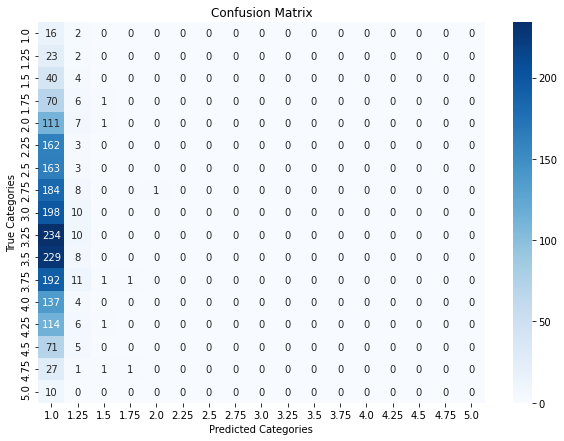

In [143]:

# Initialize the model
input_size = max_length  # the longest input is 175000
hidden_size = [1024,1024,1024]
output_size = 1  # Regression problem
activation_function = nn.ReLU
num_epochs = 20

# Create the model
modelADAM = MLP(input_size, hidden_size, output_size, activation_function)
print(modelADAM.layers)
optimizer = torch.optim.Adam(modelADAM.parameters(), lr=0.001)

# Train the model
train_model(modelADAM, optimizer, num_epochs=num_epochs)

# Evaluate the model
evaluate_model(modelADAM, test_loader)


Mean Squared Error on Test Set: 4.9358981713523535
Accuracy on Test Set: 1%
Predicted Labels: [1.0877409, 0.689826, 1.0632515, 0.95373356, 1.1319034, 0.8856083, 1.1056641, 1.0111334, 1.0454602, 0.7045275, 1.0944605, 1.0862439, 1.0615733, 1.0803237, 1.0236042, 1.017287, 1.0276983, 1.0055358, 1.1013081, 1.0996385, 0.96262026, 0.95230144, 1.0745993, 1.0924618, 1.0905802, 1.1158774, 0.7629482, 1.0802536, 0.83238405, 1.0470699, 1.0633655, 0.82305723, 0.99546534, 0.802461, 1.1408447, 0.98839784, 1.0765517, 1.078737, 1.0362712, 1.0779173, 1.0914664, 1.1437435, 1.0578535, 0.96500695, 0.86058253, 1.0722873, 0.7113944, 1.06358, 1.1474993, 1.086021, 1.0661151, 1.1609555, 1.0935754, 1.0148588, 1.1008308, 1.0672631, 1.0328845, 1.0686593, 1.0473534, 0.78791296, 0.99254775, 1.0114444, 1.0840995, 1.0775142, 1.1381097, 1.0917356, 0.86072844, 1.0691011, 1.0639642, 1.1194189, 1.1249549, 1.1122919, 1.0876181, 0.9811882, 1.0732945, 0.7801068, 0.8585676, 1.118118, 0.98085314, 1.0464593, 1.1088223, 1.0455712

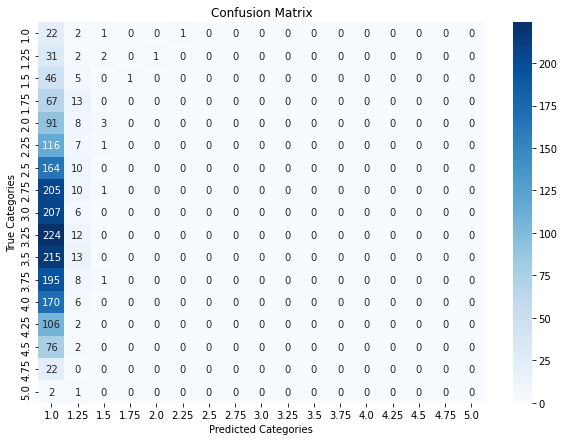

In [144]:
evaluate_model(modelADAM, validation_loader)

# SGD

ModuleList(
  (0): Linear(in_features=90948, out_features=1024, bias=True)
  (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Dropout(p=0.25, inplace=False)
  (3): ReLU()
  (4): Linear(in_features=1024, out_features=1024, bias=True)
  (5): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Dropout(p=0.25, inplace=False)
  (7): ReLU()
  (8): Linear(in_features=1024, out_features=1024, bias=True)
  (9): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): Dropout(p=0.25, inplace=False)
  (11): ReLU()
  (12): Linear(in_features=1024, out_features=1, bias=True)
)
Epoch [1/20], Loss: 6.4542
Epoch [2/20], Loss: 9.9938
Epoch [3/20], Loss: 5.6683
Epoch [4/20], Loss: 4.9563
Epoch [5/20], Loss: 4.1614
Epoch [6/20], Loss: 3.1649
Epoch [7/20], Loss: 2.3217
Epoch [8/20], Loss: 1.2657
Epoch [9/20], Loss: 1.1642
Epoch [10/20], Loss: 0.9055
Epoch [11/20], Loss: 0.7754
Epoch [12/20], 

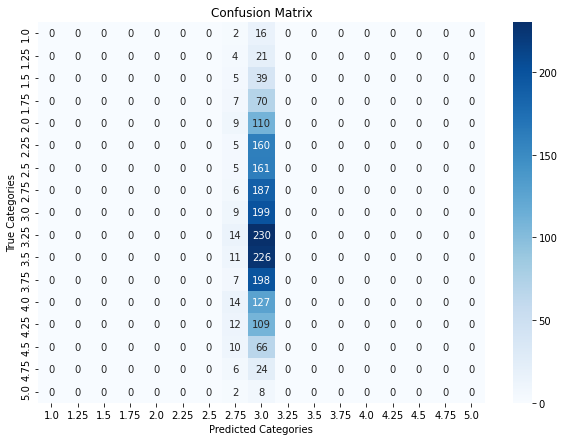

In [145]:
# Initialize the model
input_size = max_length  # the longest input is 175000
hidden_size = [1024,1024,1024]
output_size = 1  # Regression problem
activation_function = nn.ReLU
num_epochs = 20

# Create the model
modelSGD = MLP(input_size, hidden_size, output_size, activation_function)
print(modelSGD.layers)
### SGD OPTIMIZER
optimizer = torch.optim.SGD(modelSGD.parameters(), lr=0.001)

# Train the model
train_model(modelSGD, optimizer, num_epochs=num_epochs)

# Evaluate the model
evaluate_model(modelSGD, test_loader)    

## Confusion matrix

Mean Squared Error on Test Set: 0.7412769102614241
Accuracy on Test Set: 10%
Predicted Labels: [2.8878767, 2.8736308, 2.8752675, 2.8878767, 2.8878767, 2.8878767, 2.8878767, 2.8878767, 2.8097572, 2.8878767, 2.8878767, 2.8878767, 2.8878767, 2.8878767, 2.8878767, 2.8878767, 2.8807266, 2.8878767, 2.8878767, 2.8878767, 2.8878767, 2.8878767, 2.8878767, 2.8878767, 2.8878767, 2.8878767, 2.8864279, 2.8878767, 2.8817024, 2.8878767, 2.8878767, 2.8878767, 2.8878767, 2.8878767, 2.8878767, 2.8878767, 2.8878767, 2.8878767, 2.8878767, 2.8878767, 2.8878767, 2.8878767, 2.8878767, 2.8849146, 2.8878767, 2.8878767, 2.841299, 2.8878767, 2.8878767, 2.8878767, 2.8878767, 2.8878767, 2.8878767, 2.8878767, 2.8878767, 2.8878767, 2.8878767, 2.8878767, 2.8878767, 2.837556, 2.886967, 2.8878767, 2.8878767, 2.8878767, 2.8878767, 2.8878767, 2.8587604, 2.8878767, 2.8878767, 2.8878767, 2.8878767, 2.8878767, 2.8878767, 2.8878767, 2.8878767, 2.878074, 2.7427466, 2.8878767, 2.8878767, 2.8878767, 2.8878767, 2.8878767, 2.8878

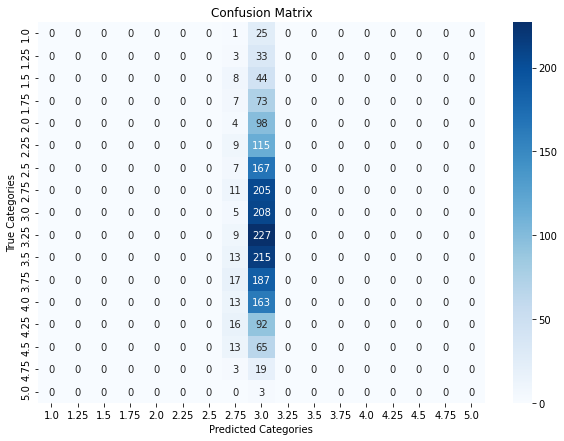

In [146]:
evaluate_model(modelSGD, validation_loader)

# RMSprop

ModuleList(
  (0): Linear(in_features=90948, out_features=1024, bias=True)
  (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Dropout(p=0.25, inplace=False)
  (3): ReLU()
  (4): Linear(in_features=1024, out_features=1024, bias=True)
  (5): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Dropout(p=0.25, inplace=False)
  (7): ReLU()
  (8): Linear(in_features=1024, out_features=1024, bias=True)
  (9): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): Dropout(p=0.25, inplace=False)
  (11): ReLU()
  (12): Linear(in_features=1024, out_features=1, bias=True)
)
Epoch [1/20], Loss: 3.1897
Epoch [2/20], Loss: 2.8157
Epoch [3/20], Loss: 3.4912
Epoch [4/20], Loss: 3.3389
Epoch [5/20], Loss: 3.0628
Epoch [6/20], Loss: 3.3633
Epoch [7/20], Loss: 2.6246
Epoch [8/20], Loss: 2.3930
Epoch [9/20], Loss: 2.1714
Epoch [10/20], Loss: 2.0428
Epoch [11/20], Loss: 1.9721
Epoch [12/20], 

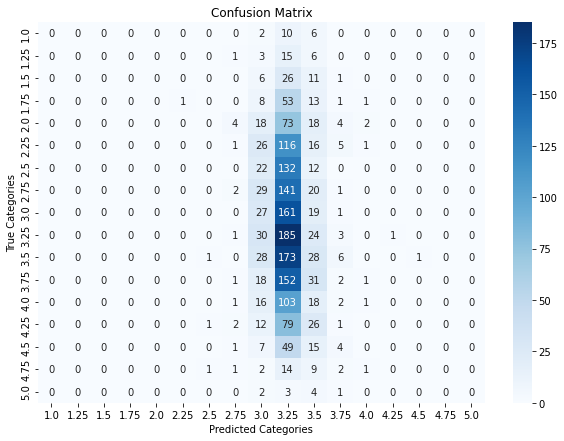

In [147]:
# Initialize the model
input_size = max_length  # the longest input is 175000
hidden_size = [1024,1024,1024]
output_size = 1  # Regression problem
activation_function = nn.ReLU
num_epochs = 20

# Create the model
modelRMS = MLP(input_size, hidden_size, output_size, activation_function)
print(modelRMS.layers)
### RMS OPTIMIZER
optimizer = torch.optim.RMSprop(modelRMS.parameters(), lr=0.001)

# Train the model
train_model(modelRMS, optimizer, num_epochs=num_epochs)

# Evaluate the model
evaluate_model(modelRMS, test_loader)    

## Confusion matrix

Mean Squared Error on Test Set: 0.7410730003048527
Accuracy on Test Set: 11%
Predicted Labels: [3.1687849, 3.4755933, 3.2381477, 3.3501751, 3.1815164, 3.3453538, 3.1274974, 3.234298, 3.5047898, 2.9985497, 3.2001088, 3.2799823, 3.226658, 3.421911, 3.316188, 3.2317698, 3.305658, 3.260798, 3.0804927, 3.1367748, 3.2449372, 3.3466218, 3.2565281, 3.1450698, 3.22061, 3.135014, 2.7280424, 3.2007163, 3.4746976, 3.2868752, 3.3196175, 3.2546594, 3.1743758, 3.2965543, 3.2187347, 3.162192, 3.204652, 3.2648547, 3.4141834, 3.1341684, 3.2740598, 3.2073667, 3.2156236, 3.2796848, 2.854386, 3.1860082, 3.3825636, 3.2895272, 3.2159288, 3.1167767, 3.2553432, 3.3823287, 3.190451, 3.253415, 3.1581428, 3.168419, 3.1765416, 3.1588497, 3.3016474, 3.3172085, 3.0749955, 3.3439867, 3.2562852, 3.261171, 3.2011425, 3.1091664, 2.9616842, 3.1821883, 3.175678, 3.2246573, 3.4935915, 3.1912715, 3.2799706, 3.253541, 3.2548776, 3.209377, 3.3638928, 3.2056623, 3.3204248, 3.1815097, 3.0968077, 3.4746516, 3.2760122, 3.1789963,

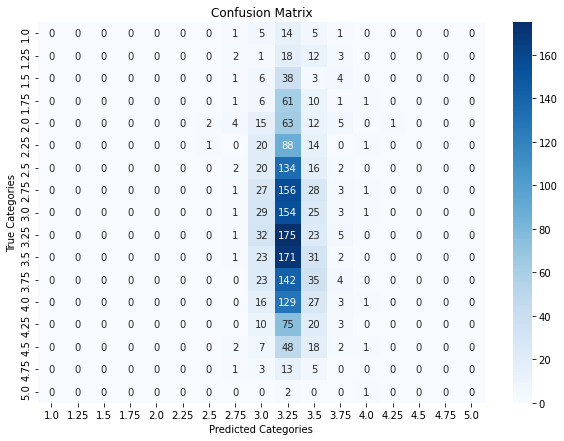

In [148]:
evaluate_model(modelRMS, validation_loader)

## AdaGrad

ModuleList(
  (0): Linear(in_features=90948, out_features=1024, bias=True)
  (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Dropout(p=0.25, inplace=False)
  (3): ReLU()
  (4): Linear(in_features=1024, out_features=1024, bias=True)
  (5): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Dropout(p=0.25, inplace=False)
  (7): ReLU()
  (8): Linear(in_features=1024, out_features=1024, bias=True)
  (9): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): Dropout(p=0.25, inplace=False)
  (11): ReLU()
  (12): Linear(in_features=1024, out_features=1, bias=True)
)
Epoch [1/20], Loss: 3.2741
Epoch [2/20], Loss: 1.2156
Epoch [3/20], Loss: 1.4228
Epoch [4/20], Loss: 0.9079
Epoch [5/20], Loss: 0.7583
Epoch [6/20], Loss: 0.8012
Epoch [7/20], Loss: 0.7128
Epoch [8/20], Loss: 0.5495
Epoch [9/20], Loss: 0.4580
Epoch [10/20], Loss: 0.6470
Epoch [11/20], Loss: 0.5150
Epoch [12/20], 

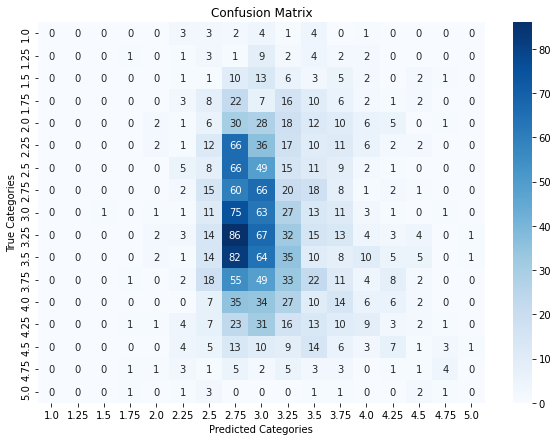

In [149]:
# Initialize the model
input_size = max_length  # the longest input is 175000
hidden_size = [1024,1024,1024]
output_size = 1  # Regression problem
activation_function = nn.ReLU
num_epochs = 20

# Create the model
modelAGRAD = MLP(input_size, hidden_size, output_size, activation_function)
print(modelAGRAD.layers)
### RMS OPTIMIZER
optimizer = torch.optim.Adagrad(modelAGRAD.parameters(), lr=0.001)

# Train the model
train_model(modelAGRAD, optimizer, num_epochs=num_epochs)

# Evaluate the model
evaluate_model(modelAGRAD, test_loader)    

Mean Squared Error on Test Set: 0.8297742939660823
Accuracy on Test Set: 11%
Predicted Labels: [2.6282184, 3.4125586, 3.1557448, 2.990715, 2.766016, 3.4558644, 2.797158, 2.5729415, 4.3221316, 1.9034579, 2.949274, 2.7954714, 3.0511644, 3.442382, 3.030413, 3.2329466, 3.3646212, 3.0357835, 2.7558706, 2.9338484, 2.1595, 4.1483207, 3.2545402, 2.921293, 3.0245583, 2.6872628, 3.6561224, 2.884914, 3.711222, 2.8137271, 2.857064, 4.107268, 2.8859293, 3.6103122, 2.8369076, 2.6825402, 2.8434823, 3.258217, 3.210223, 2.5561414, 2.94629, 3.0743911, 3.0669043, 3.5334234, 2.9739673, 2.6371465, 3.6052802, 3.0536242, 3.4772425, 2.8825219, 3.049519, 3.3262274, 3.21294, 2.9233408, 2.899945, 2.647963, 2.8753474, 2.8559954, 3.473101, 3.7925117, 2.7508147, 3.3277504, 3.0309837, 2.9440992, 2.726236, 2.8889968, 3.5137126, 2.7038884, 2.7828076, 3.0497835, 3.4147594, 3.1070578, 3.0308962, 3.263954, 3.0418599, 3.529918, 3.7245233, 3.0245612, 3.3476427, 2.8185546, 2.7568552, 3.773577, 2.759096, 2.9433203, 3.2668118

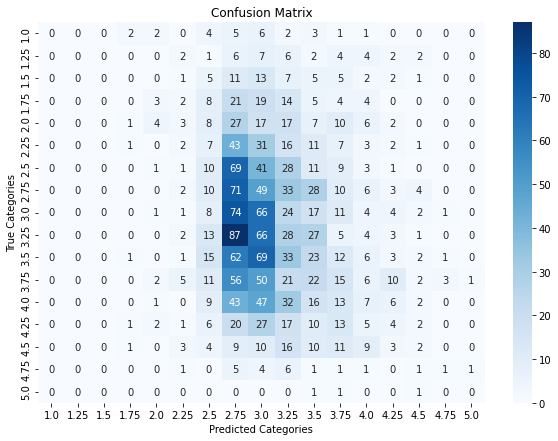

In [150]:
evaluate_model(modelAGRAD, validation_loader)